# Challenge: Add weather data to the forecast

- Check the file `data/weather_forecast_2024_04_01.csv`¹
- The data includes the forecasted weather for a given time of the day

¹ *For example, you could get this data from here: https://www.open-meteo.com/*

Your task:
- Build a feature from this data
- Integrate it into your batch model training
- Update the end-to-end pipeline for near-time prediction (forecast the next day)

# Feature Engineering

**Define the path to both data sources**

In [1]:
# Load and inspect data
energy_file_path = 'data/energy_data_2024-04-01.csv'
weather_file_path = 'data/weather_forecast_2024-04-01.csv'

**Explore the data sets**

In [2]:
import pandas as pd
energy_df = pd.read_csv(energy_file_path, parse_dates=['period']).set_index("period")
temp_df = pd.read_csv(weather_file_path, parse_dates=['period']).set_index("period")

In [5]:
energy_df

,subba,subba-name,parent,parent-name,value,value-units
period,,,,,,
2024-04-01 23:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5525,megawatthours
2024-04-01 22:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5633,megawatthours
2024-04-01 21:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5603,megawatthours
2024-04-01 20:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5616,megawatthours
2024-04-01 19:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5669,megawatthours
...,...,...,...,...,...,...
2024-01-02 04:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5038,megawatthours
2024-01-02 03:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5210,megawatthours
2024-01-02 02:00:00,ZONJ,New York City,NYIS,New York Independent System Operator,5324,megawatthours


In [4]:
temp_df

,temperature
period,
2024-01-02 00:00:00,-15.2
2024-01-02 01:00:00,-15.6
2024-01-02 02:00:00,-15.9
2024-01-02 03:00:00,-15.9
2024-01-02 04:00:00,-15.6
...,...
2024-04-01 19:00:00,-9.8
2024-04-01 20:00:00,-10.2
2024-04-01 21:00:00,-10.6


**Create a new feature store**

In [6]:
# Setting up our feature store
import os
import yaml

# Directory for feature store
directory = "feature_store"
if not os.path.exists(directory):
    os.makedirs(directory)

# Feature definitions
id = "v3"
config_data = {
    'feature_store': {
        'id': f"{id}",
        'latest_feature': "1999-01-01",
        'latest_target': "1999-01-01",
        'feature_offset': "13",
        'target_offset': "3",
        'features_path': f"feature_store/features_{id}.csv",
        'targets_path': f"feature_store/targets_v1.csv",
        'schema': {
            'features': [
                {'name': 'lag_1', 'type': 'float'},
                {'name': 'lag_4', 'type': 'float'},
                {'name': 'lag_5', 'type': 'float'},
                {'name': 'lag_6', 'type': 'float'},
                {'name': 'lag_11', 'type': 'float'},
                {'name': 'lag_12', 'type': 'float'},
                {'name': 'lag_13', 'type': 'float'},
                {'name': 'rolling_mean_7', 'type': 'float'},
                {'name': 'rolling_std_7', 'type': 'float'},
                {'name': 'temperature_forecast', 'type': 'float'} # new

            ],
            'targets': [
                {'name': 'target_1d', 'type': 'float'},
                {'name': 'target_2d', 'type': 'float'},
                {'name': 'target_3d', 'type': 'float'}
            ]
        }
    }
}

# Path to the YAML configuration file
yaml_file_path = os.path.join(directory, f"config_{id}.yaml")

# Write the configuration data to a YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

**Create the updated feature pipeline for batch processing**

(Takes now two data frames)

In [82]:
# feature pipeline

def feature_pipeline(energy_df, temp_df):
    
    energy_df_daily = energy_df.sort_index(ascending=True).resample('D').sum("value")

    batch_df = pd.DataFrame()

    # Lagging features
    batch_df['lag_1'] = energy_df_daily['value'].shift(1) # Energy demand -1 day

    batch_df['lag_4'] = energy_df_daily['value'].shift(4) # Energy demand +3 days - 7 days
    batch_df['lag_5'] = energy_df_daily['value'].shift(5) # Energy demand +2 days - 7 days
    batch_df['lag_6'] = energy_df_daily['value'].shift(6) # Energy demand +1 days - 7 days

    batch_df['lag_11'] = energy_df_daily['value'].shift(11) # Energy demand +3 days - 14 days
    batch_df['lag_12'] = energy_df_daily['value'].shift(12) # Energy demand +2 days - 14 days
    batch_df['lag_13'] = energy_df_daily['value'].shift(13) # Energy demand +1 days - 14 days

    # Rolling statistics
    batch_df['rolling_mean_7'] = energy_df_daily['value'].rolling(window=7).mean().round(2)
    batch_df['rolling_std_7'] = energy_df_daily['value'].rolling(window=7).std().round(2)

    # Bring weather data to same granularity as energy data
    temp_df_daily = temp_df.sort_index(ascending=True).resample('D').mean("value")

    # NEW: Add weather data
    batch_df = batch_df.join(temp_df_daily, how='left') # left join ensures we just add temp to where energy data exists
    batch_df = batch_df.rename(columns={"temperature": "temperature_forecast"}) # be explicit that this is the forecast about this date

    batch_df = batch_df.dropna()
    
    return batch_df

**Test the new feature pipeline**

In [83]:
feature_pipeline(energy_df, temp_df)

,lag_1,lag_4,lag_5,lag_6,lag_11,lag_12,lag_13,rolling_mean_7,rolling_std_7,temperature_forecast
period,,,,,,,,,,
2024-01-15,121604.0,129308.0,129372.0,134119.0,131606.0,131883.0,128866.0,128386.86,6264.72,-10.070833
2024-01-16,136704.0,128467.0,129308.0,129372.0,136960.0,131606.0,131883.0,130031.00,8953.19,-11.058333
2024-01-17,145628.0,119134.0,128467.0,129308.0,130213.0,136960.0,131606.0,133167.71,12008.71,-12.950000
2024-01-18,151329.0,121604.0,119134.0,128467.0,126933.0,130213.0,136960.0,135579.14,12774.85,-14.575000
2024-01-19,146188.0,136704.0,121604.0,119134.0,132752.0,126933.0,130213.0,138278.00,13015.22,-14.854167
...,...,...,...,...,...,...,...,...,...,...
2024-03-28,125867.0,118230.0,122277.0,130956.0,107680.0,109879.0,119478.0,124931.14,3900.13,-2.595833
2024-03-29,125577.0,126118.0,118230.0,122277.0,118592.0,107680.0,109879.0,123498.29,3072.37,-4.762500
2024-03-30,120926.0,125493.0,126118.0,118230.0,125016.0,118592.0,107680.0,122283.57,4819.72,-10.604167


**Build the new feature store**

In [84]:
from scripts import feature_store

batch_df = feature_pipeline(energy_df, temp_df)
feature_store.update_feature_store(batch_df, yaml_file_path)

Feature store updated with last date 2024-04-01 00:00:00


**Train the model**

In [104]:
import xgboost as xgb

X_train = feature_store.fetch_data_from_store(yaml_file_path = yaml_file_path)
X_train = X_train.head(-7) # save some rows for later
y_train = feature_store.fetch_data_from_store(X_train.index.min(), yaml_file_path, targets = True)[:X_train.index.max()]['target_1d']

# Prepare the DMatrix which is required by XGBoost
dtrain = xgb.DMatrix(data=X_train, label=y_train)

# Define XGBoost parameters
params = {
'objective': 'reg:squarederror',
'eval_metric': 'rmse'
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=999,
    nfold = 3,
    early_stopping_rounds=10,
    metrics='rmse',
    as_pandas=True,
    seed=123
)

# Show the last mean RMSE as a measure of final performance
print(f"Last mean RMSE: {cv_results['test-rmse-mean'].min()}")

Last mean RMSE: 6583.869270126056


**Inspect the learning progress**

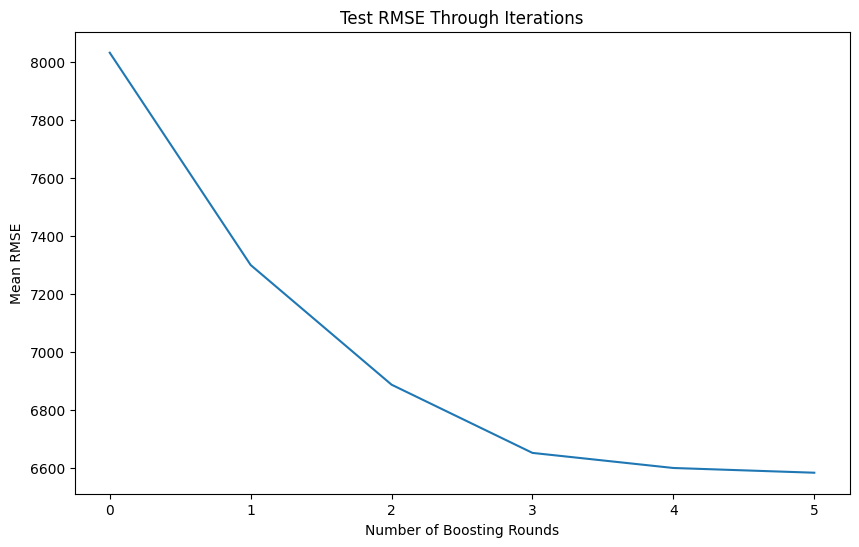

In [105]:
import matplotlib.pyplot as plt

# Plot RMSE through iterations with different colors for each line

plt.figure(figsize=(10, 6))


plt.plot(cv_results['test-rmse-mean'])

plt.title('Test RMSE Through Iterations')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Mean RMSE')
plt.show()

(TLDR; not enough data)

**Train on the full dataset**

In [106]:
# Train on whole data with ideal number of boosting rounds

# Use the same params here you used in cross-validation
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
  }

optimal_boost_rounds = cv_results['test-rmse-mean'].idxmin() + 1

# Initialize the XGBoost regressor with determined parameters
final_model = xgb.XGBRegressor(
    n_estimators=optimal_boost_rounds,
    **params
)

# Train the model on the full training dataset
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Look at the residual plots**

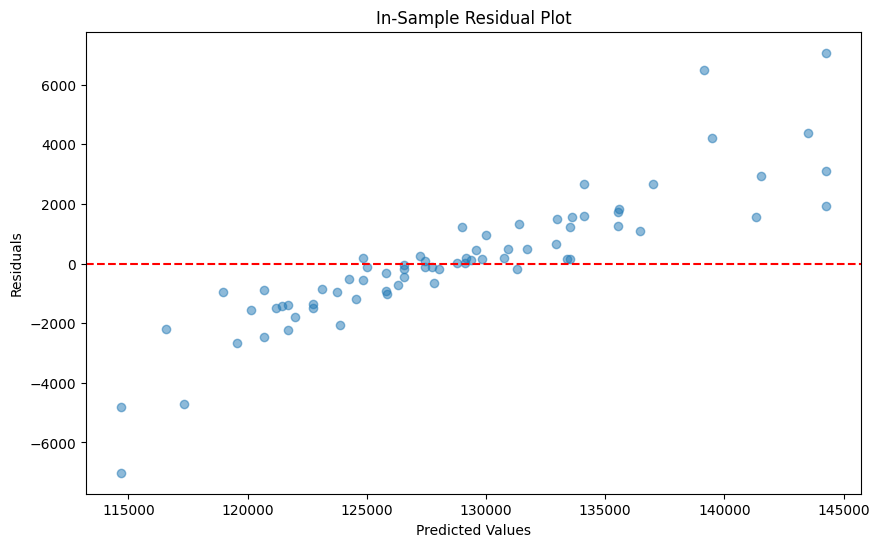

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Generate residual plos

# Plot residuals for each model
plt.figure(figsize=(10, 6))

# Make predictions
y_pred = final_model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred

# Plot residuals 
plt.scatter(y_pred, residuals, alpha=0.5)

# Add plot title and labels
plt.axhline(y=0, color='red', linestyle='--')
plt.title('In-Sample Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

**Save the model**

In [110]:
import joblib

# Save model
filename = f'models/batch_demand_forecaster_model_1_{id}.pkl' 
joblib.dump(final_model, filename)

['models/batch_demand_forecaster_model_1_v3.pkl']

**Build the end-to-end neartime workflow**

**Start with the updated online feature pipeline**

In [111]:
def feature_pipeline_online(df, temp_df):
    
    # Resample the last 24 hours relatively
    chunk_size = 24
    periods = df.index[::chunk_size]  # Select every chunk_size-th index as the period
    sums = [df.iloc[i:i + chunk_size]['value'].sum() for i in range(0, len(df), chunk_size)]
    df_daily = pd.DataFrame({'period': periods, 'value': sums})
    df_daily.set_index('period', inplace=True)
    df_daily = df_daily.sort_index(ascending = True)

    batch_df = pd.DataFrame()

    # Lagging features
    batch_df['lag_1'] = df_daily['value'].shift(1) # Energy demand -1 day

    batch_df['lag_4'] = df_daily['value'].shift(4) # Energy demand +3 days - 7 days
    batch_df['lag_5'] = df_daily['value'].shift(5) # Energy demand +2 days - 7 days
    batch_df['lag_6'] = df_daily['value'].shift(6) # Energy demand +1 days - 7 days

    batch_df['lag_11'] = df_daily['value'].shift(11) # Energy demand +3 days - 14 days
    batch_df['lag_12'] = df_daily['value'].shift(12) # Energy demand +2 days - 14 days
    batch_df['lag_13'] = df_daily['value'].shift(13) # Energy demand +1 days - 14 days

    # Rolling statistics
    batch_df['rolling_mean_7'] = df_daily['value'].rolling(window=7).mean().round(2)
    batch_df['rolling_std_7'] = df_daily['value'].rolling(window=7).std().round(2) 
    
    batch_df = batch_df.dropna()

    # NEW: Average weather for the next 24 hours
    batch_df['temperature_forecast'] = temp_df['temperature'].mean()
    
    return batch_df

**Rebuild the workflow**

In [112]:
import yaml
import joblib
import xgboost
import pandas as pd

# Step 1: Import the config variables -- 
yaml_file_path = 'feature_store/config_v1.yaml'
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)
max_offset_days = int(config['feature_store']['feature_offset'])
max_offset_hours = (max_offset_days + 1) * 24 
datetime = "2024-04-05 15:00:00" # could fetch the current hour, or the latest available data


# Step 2: Fetch a Mini-Batch of data -- 
energy_csv_file_path = 'data/energy_data_2024-04-01.csv'
temp_csv_file_path = 'data/weather_forecast_2024-04-01.csv'

# Could also be a SQL statement:
energy_mini_batch_df = (pd.read_csv(energy_csv_file_path, parse_dates=['period'])
      .set_index('period')
      .sort_index(ascending=False)
      .query("period <= @datetime"))[:max_offset_hours]

# Get forecast for the next 24 hours
temp_mini_batch = (pd.read_csv(temp_csv_file_path, parse_dates=['period'])
                   .set_index('period')
                   .sort_index(ascending = False)
                   .query("period >= @datetime")
                   .tail(24)
                   )
temp_mini_batch

# Step 3: Run the feature pipeline ---
online_features_df = feature_pipeline_online(energy_mini_batch_df, temp_mini_batch) # could be an API

# Step 4: Get the predictions ---
filename = f'models/batch_demand_forecaster_model_1_{id}.pkl' 
model = joblib.load(filename)
prediction = model.predict(online_features_df)
prediction

array([125823.16], dtype=float32)